[View in Colaboratory](https://colab.research.google.com/github/nisar009/Kaggle_Notebooks/blob/master/Copy_of_Kg_iMat_fashion.ipynb)

**Kaggle iMaterialist Challenge (Fashion) at FGVC5**

Installing Pytorch and Fastai

In [2]:
%%capture
!pip install torch torchvision

In [3]:
%%capture
!pip install fastai

In [4]:
%%capture
!pip install kaggle-cli

**Downloading Kaggle Data Set**

In [1]:
ls

datalab/


In [5]:
!mkdir -p data/fashiondata && cd data/fashiondata && kg download -u nisar009 -p p@55w0rd -c imaterialist-challenge-fashion-2018

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/test.json.zip

test.json.zip 100% |################################| Time: 0:00:00   2.3 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/validation.json.zip

validation.json.zip 100% |##########################| Time: 0:00:00   1.0 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/train.json.zip

train.json.zip 100% |###############################| Time: 0:00:01  20.0 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/sample_submission.csv.zip

sample_submission.csv.zip 100% |####################| Time: 0:00:00   1.5 MiB/s



In [6]:
!cd data/fashiondata && ls

sample_submission.csv.zip  test.json.zip  train.json.zip  validation.json.zip


In [7]:
!cd data/fashiondata && unzip sample_submission.csv.zip && unzip train.json.zip && unzip test.json.zip && unzip validation.json.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  train.json.zip
  inflating: train.json              
Archive:  test.json.zip
  inflating: test.json               
Archive:  validation.json.zip
  inflating: validation.json         


In [8]:
!cd data/fashiondata && ls

sample_submission.csv	   test.json	  train.json	  validation.json
sample_submission.csv.zip  test.json.zip  train.json.zip  validation.json.zip


Create the data set

In [9]:
import pandas as pd
import json

PATH = 'data/fashiondata/'

train_set_file = f'{PATH}train.json'

js = open(train_set_file).read()
train_data_dict = json.loads(js)
train_data_dict['images'][:5]

[{'imageId': '1',
  'url': 'https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large'},
 {'imageId': '2',
  'url': 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large'},
 {'imageId': '3',
  'url': 'https://contestimg.wish.com/api/webimage/546410237d57f323e72ca414-large'},
 {'imageId': '4',
  'url': 'https://contestimg.wish.com/api/webimage/550b955fdd699c1a0351f84e-large'},
 {'imageId': '5',
  'url': 'https://contestimg.wish.com/api/webimage/54451f33355b4e0fd3028a30-large'}]

Downloading the images with file name imageID

In [10]:
!cd data/fashiondata && mkdir -p images_train && ls

images_train		   test.json	  train.json.zip
sample_submission.csv	   test.json.zip  validation.json
sample_submission.csv.zip  train.json	  validation.json.zip


In [11]:
import urllib.request as url
import concurrent.futures as futures
import os

image_train_dir = os.path.join(PATH, 'images_train')
print(f"Downloading {len(train_data_dict['images'])} Images ...")
with futures.ThreadPoolExecutor(max_workers=30000) as executor:
  os.chdir(image_train_dir)
  for image in train_data_dict['images'][:50000]:
    imageid = image['imageId']
    imageurl = image['url']
    #image_name = os.path.join(image_train_dir, f'{imageid}.jpg')
    image_name = f'{imageid}.jpg'
    executor.submit(url.urlretrieve, f'{imageurl}', image_name)

In [12]:
!cd /content/data/fashiondata/images_train && ls -1| wc -l

49135


In [13]:
os.chdir("/content/")

In [14]:
ls

data/  datalab/


Creating the train.csv which stores < imageid, labels>

In [15]:
print(train_data_dict['annotations'][:10])

[{'labelId': ['95', '66', '137', '70', '20'], 'imageId': '1'}, {'labelId': ['36', '66', '44', '214', '105', '133'], 'imageId': '2'}, {'labelId': ['170', '66', '97', '153', '105', '138'], 'imageId': '3'}, {'labelId': ['18', '66', '44', '153', '164'], 'imageId': '4'}, {'labelId': ['189', '66', '176', '137', '153', '74', '181', '171', '138'], 'imageId': '5'}, {'labelId': ['190', '106', '53', '153', '164', '184'], 'imageId': '6'}, {'labelId': ['114', '222', '113', '176', '214', '87'], 'imageId': '7'}, {'labelId': ['18', '17', '66', '44', '98', '49', '110', '105'], 'imageId': '8'}, {'labelId': ['66', '97', '153', '181', '105', '218'], 'imageId': '9'}, {'labelId': ['91', '66', '59', '49', '151', '105', '225'], 'imageId': '10'}]


In [16]:
annotations = train_data_dict['annotations']
image_train_dict = dict()
image_train_dict['image_id'] = list()
image_train_dict['label_ids'] = list()
for annt in annotations:
  image_train_dict['image_id'].append(annt['imageId'])
  image_train_dict['label_ids'].append(" ".join(annt['labelId']))
  
train_df = pd.DataFrame(image_train_dict)
train_df.tail()

,image_id,label_ids
1014539,1014540,91 66 59 49 105 218
1014540,1014541,66 53 7 155 105 128
1014541,1014542,62 17 222 148 66 98 153 171 184
1014542,1014543,18 66 137 116 105
1014543,1014544,220 222 66 203 186


In [17]:
train_df.set_index('image_id', inplace=True)
train_df.to_csv(os.path.join(PATH, 'train_created.csv'))

We need only the downloaded image's labels in the train.csv

In [18]:
images_downloaded = os.listdir(os.path.join(PATH, 'images_train'))
images_ids_downloaded = [im.split('.')[0] for im in images_downloaded]
len(images_ids_downloaded)

49135

In [19]:
req_train_df = train_df.loc[images_ids_downloaded]
req_train_df.reset_index(inplace=True)
req_train_df['image_id'] = req_train_df['image_id'] + '.jpg'
req_train_df.set_index('image_id', inplace=True)
req_train_df.head()

,label_ids
image_id,
9898.jpg,201 66 138
18409.jpg,200 106 224
12790.jpg,190 66 53 49 181 164
25965.jpg,106 49 105 73
26106.jpg,62 66 98 171 133


In [20]:
req_train_df.sort_index()
#req_train_df.loc['1']
req_train_df.to_csv(os.path.join(PATH, 'train_req.csv'))

In [21]:
!cd data/fashiondata && ls

images_train		   test.json.zip      train_req.csv
sample_submission.csv	   train_created.csv  validation.json
sample_submission.csv.zip  train.json	      validation.json.zip
test.json		   train.json.zip


## **Starting from fastai**

In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastai Imports

In [23]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import*

In [24]:
PATH = "data/fashiondata/"
os.makedirs('data/fashiondata/models', exist_ok=True)
os.makedirs('data/fashiondata/tmp', exist_ok=True)
!ls {PATH}

images_train		   test.json.zip      train_req.csv
models			   tmp		      validation.json
sample_submission.csv	   train_created.csv  validation.json.zip
sample_submission.csv.zip  train.json
test.json		   train.json.zip


F1 Score as Metric

In [25]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 1, average='samples')
                    for th in np.arange(start,end,step)])
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

epoch      trn_loss   val_loss   f1         
    0      0.100387   0.077952   0.398227  


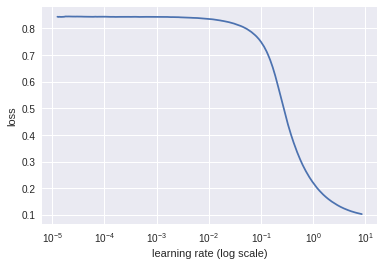

In [37]:
metric = [f1]
sz=64
arch=resnet34
# Lets train a model
def get_data(size):
  tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  return ImageClassifierData.from_csv(path=PATH,
                                      folder='images_train',
                                      csv_fname=f'{PATH}train_req.csv',
                                     tfms=tfms)
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metric)
lrf = learn.lr_find()
learn.sched.plot()


In [32]:
 lr = 0.5
#learn.precompute=False
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, use_swa=True, swa_start=3)

epoch      trn_loss   val_loss   f1         swa_loss   swa_f1     
    0      0.081411   0.076004   0.419689  
 45%|████▌     | 277/615 [00:08<00:10, 33.78it/s, loss=0.0787]

    1      0.077654   0.073021   0.435398  
    2      0.07629    0.072594   0.438281   0.072694   0.43781   
  1%|          | 4/615 [00:00<00:58, 10.47it/s, loss=0.0765]

    3      0.074838   0.071665   0.443207  
 75%|███████▌  | 462/615 [00:12<00:04, 36.08it/s, loss=0.074] 

    4      0.073678   0.071019   0.44786   
    5      0.073136   0.070836   0.448589  
 13%|█▎        | 79/615 [00:02<00:14, 36.92it/s, loss=0.0729]

    6      0.073073   0.070795   0.449108   0.071247   0.446183  


[array([0.07079]), 0.4491082194918943, array([0.07125]), 0.446183402209343]

In [33]:
# Differential Learning Rates for Different Layer Groups
lrs = np.array([lr/9, lr/3, lr])

In [36]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, use_swa=True, swa_start=3, wds=[3e-4], use_wd_sched=True, norm_wds=True)
learn.save('resnet34_64')

  5%|▌         | 32/615 [00:22<06:50,  1.42it/s, loss=0.688]

KeyboardInterrupt: ignored

In [0]:
data = get_data(128)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   f1         
    0      0.079864   0.075187   0.419065  
  5%|▍         | 34/738 [00:22<07:53,  1.49it/s, loss=0.0798]

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('resnet34_128')

In [0]:
data = get_data(128)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('resnet34_254')